# Model Baio

## Overview
- Estimate characteristics of associaton football teams, that explain the strength and weaknesses of teams playing against each other (Estimation of effects explaining the number of goals). This also allows for scores prediction of particular matches

## Model
- Bayesian Hierarchical Model (natural way of taking relations between variables into account, by assuming a common distribution for their paramters). Correlation is taken into account, since variables are mixed at an upper level.
- Two indepentent Poisson variables for outcomes, with paramters being a product of a attack strength parameter for the one team and a defense weakness (negative sign!) paramter for the opposing team (Log linear model).


## Methodology
1. Identify relevant data
2. Define (descriptive and meaningful) Model
3. Specify priors
4. Conduct Inference (and sanity check)
5. Posterior Predictive Check

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Identify Relevant Data

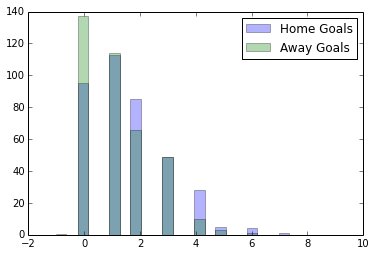

,team,logstart
0,Arsenal,0.521297
1,Chelsea,0.387766
2,Manchester United,0.610909
3,Liverpool,0.926762
4,Newcastle United,0.051293
5,Aston Villa,-0.111226
6,Fulham,-0.171850
7,Southampton,0.146603
8,Everton,0.191055
9,Tottenham Hotspur,0.274437


In [2]:
# Import season 2014/15 fixtures
# df = pd.read_csv('./data/s14-15.csv')
df = pd.read_csv('./data/s13-14.csv')

# Build team index
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

# Observed goals stats (Eyeball Poisson)
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

bins = np.linspace(-1, 10, 30)
plt.hist(observed_home_goals, bins, alpha=0.3, label='Home Goals')
plt.hist(observed_away_goals, bins, alpha=0.3, label='Away Goals')
plt.legend(loc='upper right')
plt.show()

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

# Informed starting point (for what?) by using empirical log mean
# log mean score of each away and home team
# (From the perspective of the away team? - negative home log scores)
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

df = pd.DataFrame(teams['team'])
df['logstart'] = att_starting_points
df

## 2. - 3. Define Model & Specify Priors

In [3]:
with pm.Model() as model:    
    # global model parameters
    home        = pm.Normal('home', mu=0, tau=0.0001)
    mu_att      = pm.Normal('mu_att', mu=0, tau=0.0001)
    mu_def      = pm.Normal('mu_def', mu=0, tau=0.0001)
    tau_att     = pm.Gamma('tau_att', alpha=0.1, beta=0.1)
    tau_def     = pm.Gamma('tau_def', alpha=0.1, beta=0.1)
    intercept   = pm.Normal('intercept', mu=0, tau=0.0001)

    # team-specific model parameters
    # TODO: why is mu not a random variable? Is it becasue we center data to
    # reduce uncertainty about the mean?
    atts_star   = pm.Normal("atts_star",
                           mu = 0,
                           tau = tau_att,
                           shape = num_teams)
    defs_star   = pm.Normal("defs_star",
                           mu = 0,
                           tau = tau_def,
                           shape = num_teams)

    # TODO: why center the data? => to make parameters interpretable. Otherwise, just
    # arbitrary estimates to fit the data
    atts        = pm.Deterministic('atts', atts_star - tt.mean(atts_star)) #identifieability
    defs        = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta  = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta  = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.


## 4. Conduct Inference & Sanity Check

In [4]:
# Fit data, starting with the MAP
with model:    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(10000, step, start=start)

 [-----------------100%-----------------] 10000 of 10000 complete in 188.4 sec

array([[<matplotlib.axes.AxesSubplot object at 0x12c60fa10>,
        <matplotlib.axes.AxesSubplot object at 0x12d6e3690>]], dtype=object)

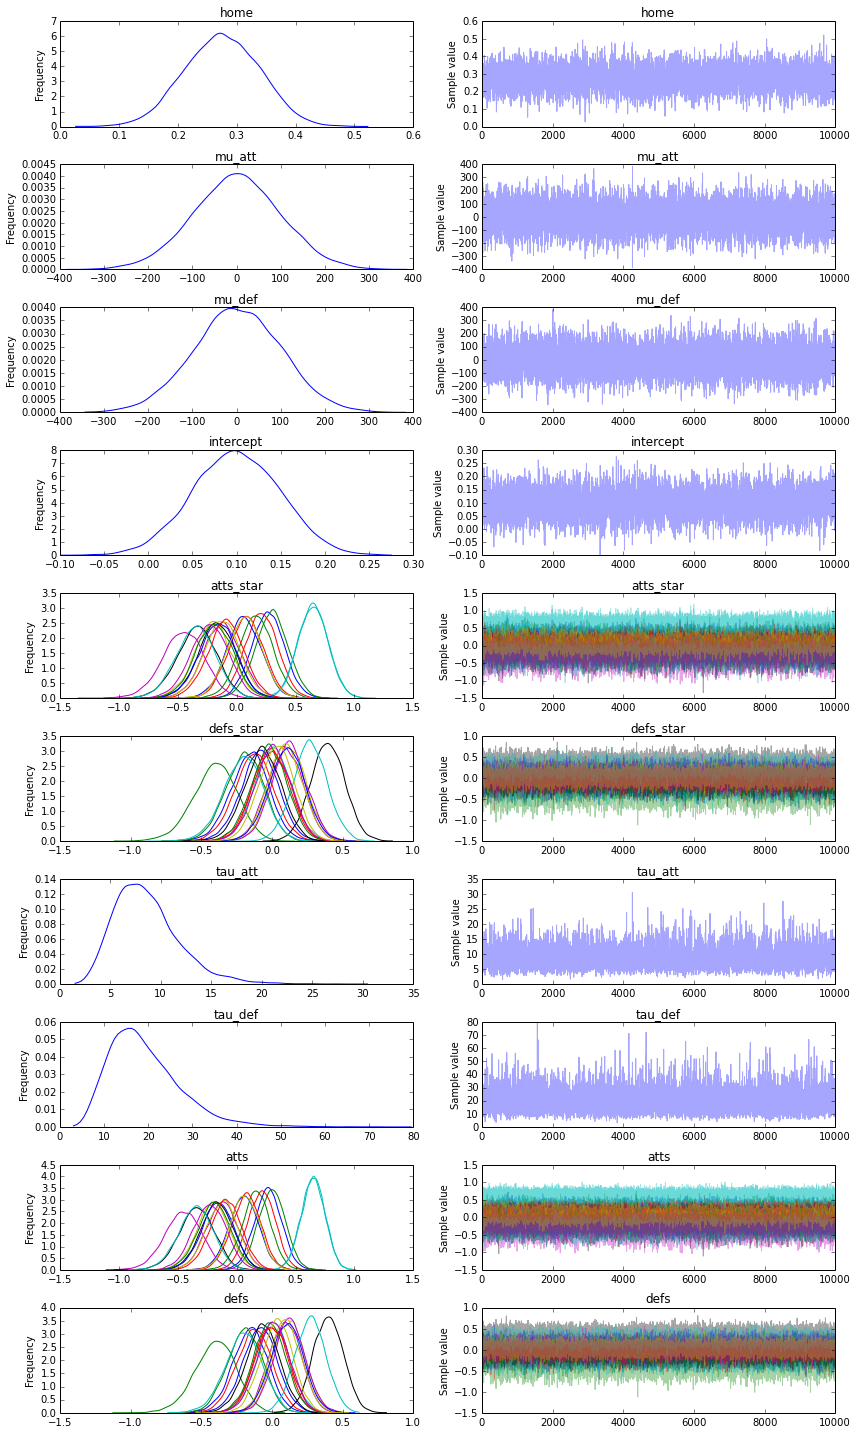

In [5]:
# Plot posteriors
pm.traceplot(trace)

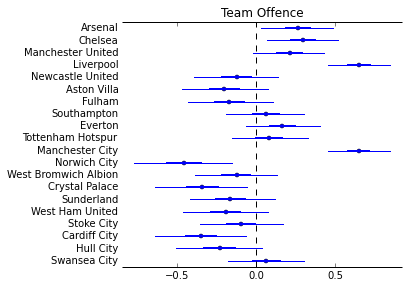

In [6]:
# Plot attack parameters
pm.forestplot(trace, varnames=['atts'], ylabels=df['team'].values, main="Team Offence")

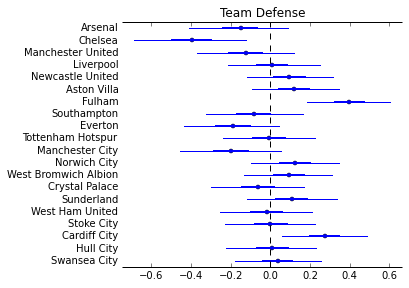

In [7]:
# Plot defense parameters
pm.forestplot(trace, varnames=['defs'], ylabels=df['team'].values, main="Team Defense")
# Negative scoring intensity is desired!

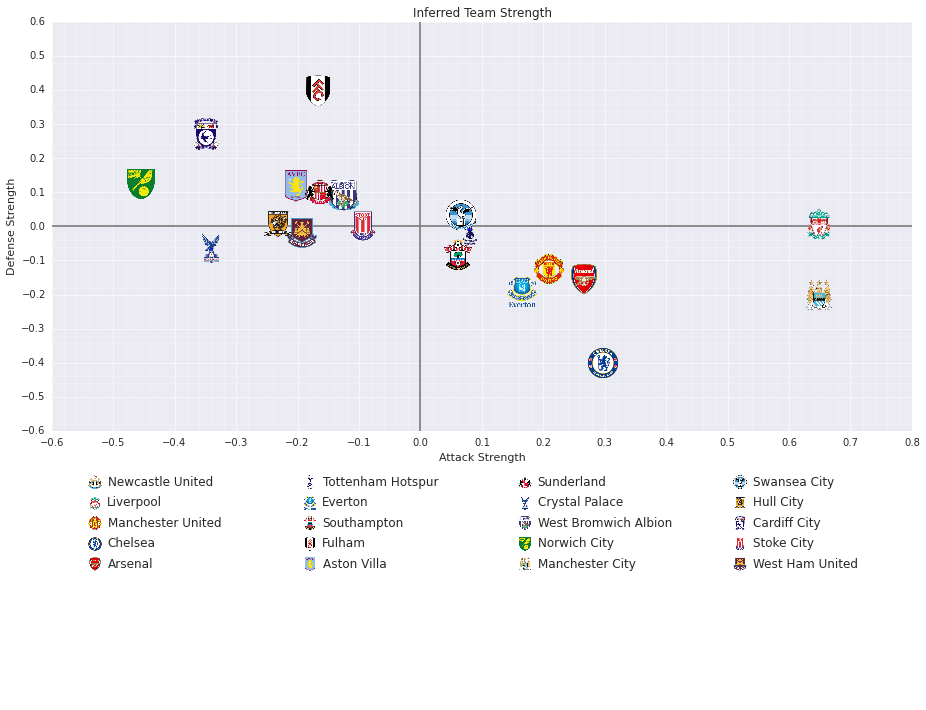

In [257]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 1, width_ratios=[1,1], height_ratios=[2,1])

fig = plt.figure(figsize=(25, 10))

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])

ax1.axis([-0.6, 0.8, -0.6, 0.6])

ax1.set_xticks(np.arange(-0.6, 0.85, 0.1))
ax1.set_xticks(np.arange(-0.6, 0.8, 0.02), minor=True)
ax1.set_yticks(np.arange(-0.6, 0.65, 0.1))
ax1.set_yticks(np.arange(-0.6, 0.6, 0.02), minor=True)                                                     

ax1.yaxis.grid(True, which='major', alpha=0.5)
ax1.yaxis.grid(True, which='minor', alpha=0.2)
ax1.xaxis.grid(True, which='major', alpha=0.5)
ax1.xaxis.grid(True, which='minor', alpha=0.2)

ax1.axhline(0, color='grey')
ax1.axvline(0, color='grey')

ax1.set_xlabel('Attack Strength')
ax1.set_ylabel('Defense Strength')
ax1.set_title("Inferred Team Strength")

# ax1.set_axis_bgcolor('white')
# plt.setp(ax.spines.values(), color='black')
# plt.setp([ax1.get_xticklines(), ax1.get_yticklines()], color='black')

for k,v in enumerate(lv.values):
    x = lv.iloc[k]['attack']
    y = lv.iloc[k]['defense']
    
    team = lv.iloc[k]['team'].lower().replace(" ", "_")
    
    handles.append(ax1.scatter(x,y))
    
    file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
    icon = read_png(file)
    imagebox = OffsetImage(icon, zoom=0.125)

    ab = AnnotationBbox(imagebox, (x,y), frameon=False)
    ax1.add_artist(ab)

ax2.axis('off')
    
for k,v in enumerate(lv.values):
    if (k <= 4):
        x = 0
        y = k * 0.1
    elif (k <= 9):
        x = 0.25
        y = (k-5)*0.1
    elif (k <= 14):
        x = 0.5
        y = (k-10)*0.1
    else:
        x = 0.75
        y = (k-15)*0.1
    
    team = lv.iloc[k]['team'].lower().replace(" ", "_")
    team_name = lv.iloc[k]['team']
    
    file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
    icon = read_png(file)
    imagebox = OffsetImage(icon, zoom=0.055)

    crest = AnnotationBbox(imagebox, (x+0.05,y+0.015+0.58), frameon=False)
    ax2.add_artist(crest)
    ax2.annotate(team_name, xy=(x+0.015+0.05,y+0.58))

fig.tight_layout()

plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/team-parameters.pdf",bbox_inches='tight')
    
plt.show()

## 5. Posterior Predictive Check

In [ ]:
ppc = pm.sample_ppc(trace, samples=1, model=model, size=100)

In [ ]:
print(ppc['away_points'].shape)
ppc['home_points']
observed_home_goals
observed_away_goals


In [ ]:
# for each of the 380 fixtures: 1 generated data set, containing 100 samples
ppc['away_points'].shape

In [ ]:
# Calculate mean for every generated dataset
# for fix in range(0,380):
#     away_means = [n.mean() for n in ppc['away_points']]

away = ppc['away_points']
away = np.squeeze(away)
away = np.swapaxes(away,0,1)
# away_means = [n.mean() for n in away]

print(away.shape)

home = ppc['home_points']
home = np.squeeze(home)
home = np.swapaxes(home,0,1)
# away_means = [n.mean() for n in away]

print(home.shape)
type(home)

In [ ]:
# GOAL: Posterior for the marginal of the joint observation P(Y_0, Y1) (i.e. team 0 playing home and 1 playing away)
# We have the set of samples, which is representative for this posterior.
# Game 01 is game 1 from 380, hence at index 0
# print(np.where(home_team == 0))
# print(np.where(away_team == 1))

# [1] Marginalise over event likelihoods Win/Draw/Loss
# lets get the sample for the home observation variables Y0 and for Y1 (marginals)
margY0 = home[0]
margY1 = home[1]

#print(margY0.mean()) # Arsenal: slightly weaker offence but more significantly weaker defense then Chelsea
#print(margY1.mean()) # Chelsea

# Mean result prediction seems to make sense

# Now to calulate the probability of winning we define the events win/draw/loss as follows
# -> paper Louzada et al.

# [2] Goal Difference Likelihood for match 0 agains 1 (how does this relate to [1]?)
match_0_home = home[0]
match_0_away = away[1]

gd = [x[0]-x[1] for x in zip(match_0_home, match_0_away)]
from collections import Counter
freqs = Counter(gd).items()

rel_freqs = [(x[0],float(x[1])/100) for x in freqs]

win = [x[1] for x in rel_freqs if x[0] > 0]
loss = [x[1] for x in rel_freqs if x[0] < 0]
draw = [x[1] for x in rel_freqs if x[0] == 0]

print "Team 0 chances are: Win %f, Loss %f, Draw %f" %(sum(win), sum(loss), sum(draw))

## Simulate Season 2014/2015

In [ ]:
# Calculate goal differences
from collections import Counter

predictions = []

# Save odds for outcomes for each fixture
exp_win = np.empty(380,)
exp_draw = np.empty(380,)
exp_loss = np.empty(380,)
exp_events = np.chararray((380,)) # expected events
real_events = np.chararray((380,)) # Realised events
    
for g in range(num_games): # num_games
    g_home = home[g]
    g_away = away[g]
    g_home_team = home_team[g]
    g_away_team = away_team[g]
    home_teamname = teams['team'][g_home_team]
    away_teamname = teams['team'][g_away_team]    
    
    g_diff = [x[0] - x[1] for x in zip(g_home, g_away)]
    freqs = Counter(g_diff).items()

    rel_freqs = [(x[0],float(x[1])/100) for x in freqs]

    exp_win[g] = sum([x[1] for x in rel_freqs if x[0] > 0])
    exp_draw[g] = sum([x[1] for x in rel_freqs if x[0] == 0])
    exp_loss[g] = sum([x[1] for x in rel_freqs if x[0] < 0])
    
    results = [exp_win[g], exp_draw[g], exp_loss[g]] # 0 = win; 1 = draw; 2 = loss;
    event_mnemonics = ['Win', 'Draw', 'Loss']
    exp_events[g] = event_mnemonics[results.index(max(results))]
    
    actual_g_diff = observed_home_goals[g] - observed_away_goals[g]
    if (actual_g_diff > 0): real_events[g] = event_mnemonics[0]
    elif (actual_g_diff == 0): real_events[g] = event_mnemonics[1]
    else: real_events[g] = event_mnemonics[2]
    
    # Calculate overall accuracy (not too meaningful)
#     if (actual_event == event):
#         predictions.append(1)
#     else:
#         predictions.append(0)
            
#     if (g%38 == 0):
#         print "%s VS. %s: %s || %s" %(home_teamname, away_teamname, event, actual_event)
    
    # Group w.r.t. winning odds!
    # -> idea: i want 1000 times the same fixture to see if my 53% win forecast is true. since i don't hvae that
    #          i group all teams with similar odds and check then!
    
# float(sum(predictions))/num_games
exp_events
real_events

# Check if properly normalised
# What to do about precision??
(exp_loss + exp_win + exp_draw) == 1

## Calculate log-likelihood
# exp_* arrays contain the relative frequencies of the respective
# events from the simulated fixtures (100 samples each)
# We look at the actual realised fixture results in real_events
# and add the log-likelihood our model assigns this result for every individual outcome 
likelihood = np.empty(380,)

for g,event in enumerate(real_events):
    if (event == 'W'): likelihood[g] = exp_win[g]
    elif (event == 'D'): likelihood[g] = exp_draw[g]
    else: likelihood[g] = exp_loss[g]
        
ll = np.log(likelihood)

# Output avg. log likelihood for total season 13/14
avg_ll = ll.sum()/len(ll)
bias = 0

print "Avg LL = " + str(avg_ll)
print "Bias = " + str(bias)

In [ ]:
from scipy.stats import poisson

home_mean = trace['home'].mean()
intercept_mean = trace['intercept'].mean()
defs_mean = trace['atts'].mean(axis=0)
atts_mean = trace['defs'].mean(axis=0)
ll = 0
for g in range(num_games):
    lbda_home = np.exp(home_mean + atts_mean[home_team[g]] + defs_mean[away_team[g]] + intercept_mean)
    lbda_away = np.exp(atts_mean[away_team[g]] + defs_mean[home_team[g]] + intercept_mean)

    # Independent Poisson
    p_home = poisson.pmf(observed_home_goals[g], lbda_home)
    p_away = poisson.pmf(observed_away_goals[g], lbda_away)

    ll += np.log(p_home * p_away)

print ll / num_games

### Calibration Plot
- GD or Goals or Home/Away Goals separate or ...?
- X-axis: True probability of shooting n goals
- Y-axis: Predicted probability of shooting n goals

In [ ]:
# Callibrated home goals
home_goal_freqs = Counter(observed_home_goals).items()
home_goal_rel_freqs = [(x[0],float(x[1])/len(observed_home_goals)) for x in home_goal_freqs]
home_goal_rel_freqs

from scipy import stats

home_swapped = np.swapaxes(home,0,1)
home_mode_goals = np.squeeze(stats.mode(home_swapped)[0])

home_mode_goal_freqs = Counter(home_mode_goals).items()
home_mode_goal_rel_freqs = [(x[0],float(x[1])/len(home_mode_goals)) for x in home_mode_goal_freqs]
home_mode_goal_rel_freqs.append((5,0))
home_mode_goal_rel_freqs.append((6,0))
home_mode_goal_rel_freqs.append((7,0))

x = [x[1] for x in home_goal_rel_freqs]
y = [y[1] for y in home_mode_goal_rel_freqs]

plt.scatter(x,y)
plt.plot(x,x)

In [ ]:
# Callibrated away goals
away_goal_freqs = Counter(observed_away_goals).items()
away_goal_rel_freqs = [(x[0],float(x[1])/len(observed_away_goals)) for x in away_goal_freqs]
away_goal_rel_freqs

from scipy import stats

away_swapped = np.swapaxes(away,0,1)
away_mode_goals = np.squeeze(stats.mode(away_swapped)[0])

away_mode_goal_freqs = Counter(away_mode_goals).items()
away_mode_goal_rel_freqs = [(x[0],float(x[1])/len(away_mode_goals)) for x in away_mode_goal_freqs]
away_mode_goal_rel_freqs.append((5,0))
away_mode_goal_rel_freqs.append((6,0))

x = [x[1] for x in away_goal_rel_freqs]
y = [y[1] for y in away_mode_goal_rel_freqs]
z = range(1,9)

plt.scatter(x,y)
plt.plot(x,x)